In [79]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
!pip install xgboost
import xgboost as xgb
from xgboost import XGBClassifier

In [80]:
X_train = pd.read_csv('/content/BuyAffinity_Train.txt', sep = '\t')

In [81]:
X_train.head()

,Index,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,C
0,1,0.224506,0.500340,0.489860,0.902413,7934,-6970,-5714,9982,-5697,4227810299,-3918676258,316195953,6176861823,-3433637453,10/4/1986,9/6/1992,2,1,706,305,1,2,0
1,2,0.321128,0.281119,0.907283,0.772159,-8238,1219,1663,1287,-3658,-1146724819,-6837090439,1378635942,-9031507610,609277486,2/24/1979,1/5/1983,1,1,423,206,18,7,1
2,3,0.893441,0.622005,0.998776,0.098386,8540,5266,-9377,-3504,-4511,5947184989,6881163164,-9921889287,-5610051842,-8977995005,1/12/1989,11/22/1986,2,1,703,315,1,4,0
3,4,0.320641,0.957234,0.346000,0.646479,-7772,-383,9681,-8661,3474,-5724795826,-6014104498,6550322883,-4697085930,4868760308,2/18/1982,6/10/1992,1,1,122,304,15,1,0
4,5,0.475961,0.623008,0.544988,0.159709,1571,-8039,-7961,-2385,4407,-3097637172,-9755731483,759031103,9984692447,9757408267,4/10/1987,10/19/1985,1,1,486,240,1,1,0


In [82]:
X_train.drop(['Index'], axis = 1,inplace = True)

In [83]:
X_train.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,C
0,0.224506,0.500340,0.489860,0.902413,7934,-6970,-5714,9982,-5697,4227810299,-3918676258,316195953,6176861823,-3433637453,10/4/1986,9/6/1992,2,1,706,305,1,2,0
1,0.321128,0.281119,0.907283,0.772159,-8238,1219,1663,1287,-3658,-1146724819,-6837090439,1378635942,-9031507610,609277486,2/24/1979,1/5/1983,1,1,423,206,18,7,1
2,0.893441,0.622005,0.998776,0.098386,8540,5266,-9377,-3504,-4511,5947184989,6881163164,-9921889287,-5610051842,-8977995005,1/12/1989,11/22/1986,2,1,703,315,1,4,0
3,0.320641,0.957234,0.346000,0.646479,-7772,-383,9681,-8661,3474,-5724795826,-6014104498,6550322883,-4697085930,4868760308,2/18/1982,6/10/1992,1,1,122,304,15,1,0
4,0.475961,0.623008,0.544988,0.159709,1571,-8039,-7961,-2385,4407,-3097637172,-9755731483,759031103,9984692447,9757408267,4/10/1987,10/19/1985,1,1,486,240,1,1,0


In [84]:
#since no information is given about the columns so i asssume that columns having dates are irrelevant to the  prediction.

In [85]:
X_train.drop(['F15','F16'], axis = 1,inplace = True)

In [86]:
#checking NULL
X_train.isna().sum()

F1     0
F2     0
F3     0
F4     0
F5     0
F6     0
F7     0
F8     0
F9     0
F10    0
F11    0
F12    0
F13    0
F14    0
F17    0
F18    0
F19    0
F20    0
F21    0
F22    0
C      0
dtype: int64

In [87]:
X = X_train.drop('C', axis = 1)
Y = X_train['C'].copy()

In [88]:
X.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F17,F18,F19,F20,F21,F22
0,0.224506,0.500340,0.489860,0.902413,7934,-6970,-5714,9982,-5697,4227810299,-3918676258,316195953,6176861823,-3433637453,2,1,706,305,1,2
1,0.321128,0.281119,0.907283,0.772159,-8238,1219,1663,1287,-3658,-1146724819,-6837090439,1378635942,-9031507610,609277486,1,1,423,206,18,7
2,0.893441,0.622005,0.998776,0.098386,8540,5266,-9377,-3504,-4511,5947184989,6881163164,-9921889287,-5610051842,-8977995005,2,1,703,315,1,4
3,0.320641,0.957234,0.346000,0.646479,-7772,-383,9681,-8661,3474,-5724795826,-6014104498,6550322883,-4697085930,4868760308,1,1,122,304,15,1
4,0.475961,0.623008,0.544988,0.159709,1571,-8039,-7961,-2385,4407,-3097637172,-9755731483,759031103,9984692447,9757408267,1,1,486,240,1,1


In [89]:
Y.head()

0    0
1    1
2    0
3    0
4    0
Name: C, dtype: int64

**Checking for Collinearity Between Features and Creating Reducing Feature Size**

In [90]:
corr_matrix = X.corr().abs()

In [91]:
corr_matrix.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F17,F18,F19,F20,F21,F22
F1,1.000000,0.004133,0.000362,0.000068,0.002246,0.004772,0.002282,0.004885,0.003566,0.000542,0.000370,0.000173,0.001954,0.000280,0.002261,0.000322,0.005119,0.000737,0.003524,0.001905
F2,0.004133,1.000000,0.002162,0.002540,0.000784,0.001918,0.007180,0.001264,0.001359,0.003328,0.003369,0.000495,0.000195,0.003321,0.003455,0.000010,0.000049,0.003102,0.000882,0.000089
F3,0.000362,0.002162,1.000000,0.001951,0.004431,0.003048,0.002919,0.002998,0.000022,0.000009,0.000893,0.001373,0.002150,0.002402,0.000770,0.003763,0.001752,0.001445,0.000393,0.001722
F4,0.000068,0.002540,0.001951,1.000000,0.001021,0.002239,0.002765,0.003080,0.000362,0.001897,0.003646,0.005809,0.001284,0.001984,0.006168,0.004088,0.002143,0.002606,0.002783,0.002746
F5,0.002246,0.000784,0.004431,0.001021,1.000000,0.001416,0.001278,0.002407,0.001892,0.001449,0.000282,0.001567,0.001665,0.001270,0.001536,0.006480,0.000906,0.003904,0.006321,0.000606


In [92]:
#upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

In [93]:
# Find index of feature columns with correlation greater than 0.6
to_drop = [column for column in upper.columns if any(upper[column] > 0.6)]

In [94]:
to_drop

['F19', 'F20']

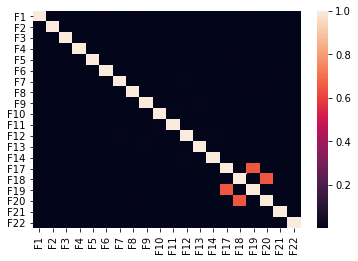

In [95]:
sns.heatmap(corr_matrix, xticklabels=corr_matrix.columns,yticklabels=corr_matrix.columns)

In [96]:
#Independent highly corelated variables.
X = X.drop(columns = to_drop)

In [97]:
X.shape

(101180, 18)

<Figure size 432x288 with 0 Axes>

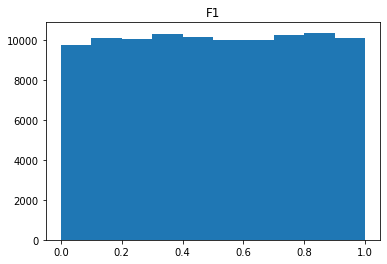

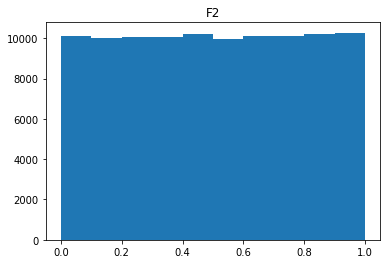

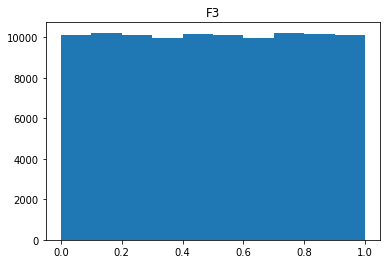

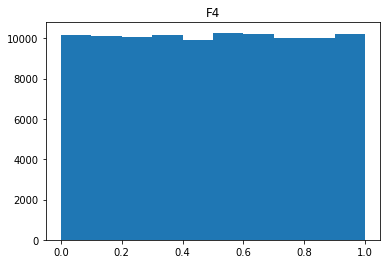

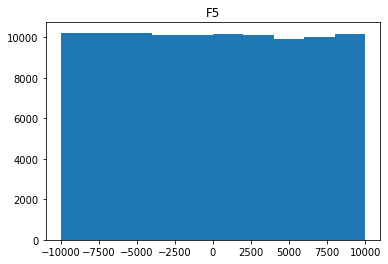

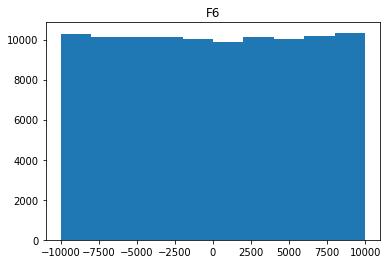

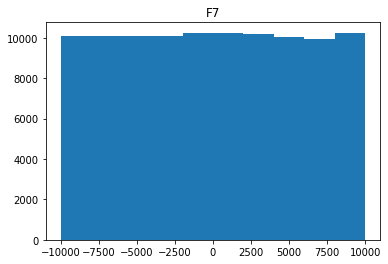

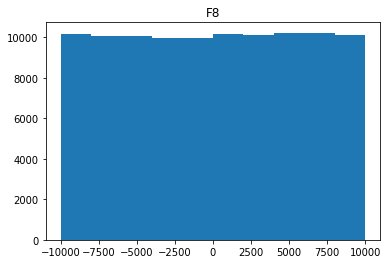

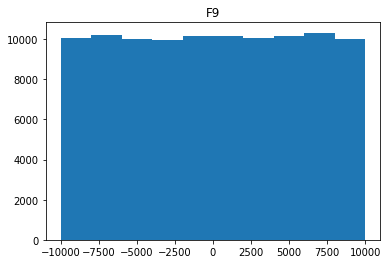

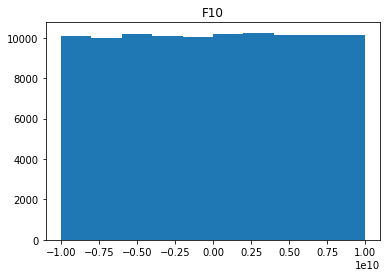

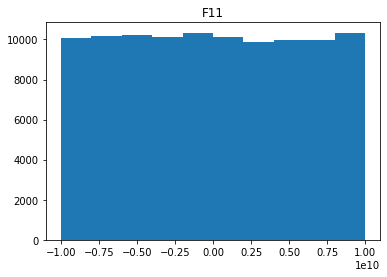

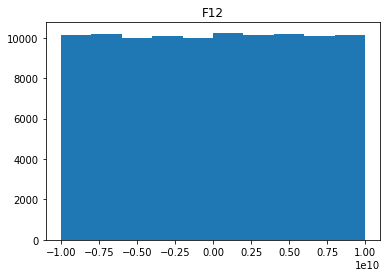

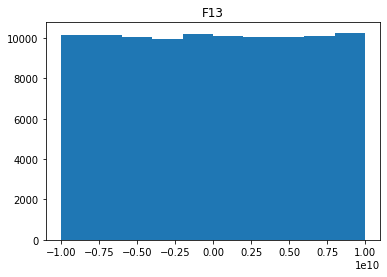

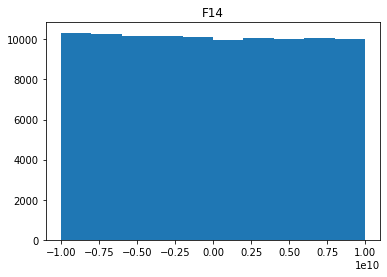

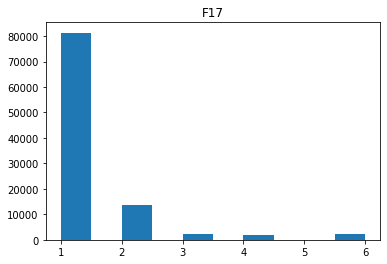

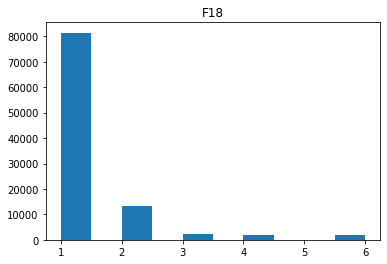

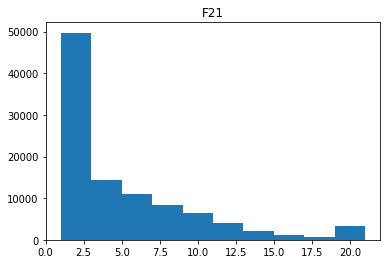

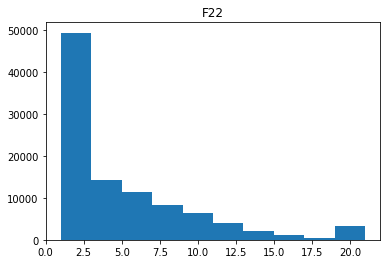

In [98]:
# Histogram of all features
for idx,column in enumerate(X.columns): 
    plt.figure(idx)
    X.hist(column=column,grid=False)

In [99]:
# Checking for NA values
for i in X.columns:
    print('Feature:',i)
    print('# of N/A:',X[i].isna().sum())

Feature: F1
# of N/A: 0
Feature: F2
# of N/A: 0
Feature: F3
# of N/A: 0
Feature: F4
# of N/A: 0
Feature: F5
# of N/A: 0
Feature: F6
# of N/A: 0
Feature: F7
# of N/A: 0
Feature: F8
# of N/A: 0
Feature: F9
# of N/A: 0
Feature: F10
# of N/A: 0
Feature: F11
# of N/A: 0
Feature: F12
# of N/A: 0
Feature: F13
# of N/A: 0
Feature: F14
# of N/A: 0
Feature: F17
# of N/A: 0
Feature: F18
# of N/A: 0
Feature: F21
# of N/A: 0
Feature: F22
# of N/A: 0


In [100]:
#Checking Unique values in each columns
for i in X_train.columns:
    print('####################')
    print('COLUMN TITLE:',i)
    print('# UNIQUE VALUES:',len(X_train[i].unique()))
    print('UNIQUE VALUES:',X_train[i].unique())
    print('####################')
    print()

####################
COLUMN TITLE: F1
# UNIQUE VALUES: 101176
UNIQUE VALUES: [0.22450589 0.32112831 0.89344077 ... 0.90913683 0.90149544 0.86851935]
####################

####################
COLUMN TITLE: F2
# UNIQUE VALUES: 101169
UNIQUE VALUES: [0.50033982 0.28111875 0.62200544 ... 0.52186917 0.54620298 0.18758067]
####################

####################
COLUMN TITLE: F3
# UNIQUE VALUES: 101179
UNIQUE VALUES: [0.48986028 0.90728298 0.99877582 ... 0.23366712 0.61066321 0.74606355]
####################

####################
COLUMN TITLE: F4
# UNIQUE VALUES: 101178
UNIQUE VALUES: [0.90241272 0.77215857 0.09838625 ... 0.8794933  0.8051365  0.60888396]
####################

####################
COLUMN TITLE: F5
# UNIQUE VALUES: 19876
UNIQUE VALUES: [ 7934 -8238  8540 ...   558  5837 -2496]
####################

####################
COLUMN TITLE: F6
# UNIQUE VALUES: 19862
UNIQUE VALUES: [-6970  1219  5266 ...  5270  4796  6839]
####################

####################
COLUMN TITLE: F

In [101]:
X

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F17,F18,F21,F22
0,0.224506,0.500340,0.489860,0.902413,7934,-6970,-5714,9982,-5697,4227810299,-3918676258,316195953,6176861823,-3433637453,2,1,1,2
1,0.321128,0.281119,0.907283,0.772159,-8238,1219,1663,1287,-3658,-1146724819,-6837090439,1378635942,-9031507610,609277486,1,1,18,7
2,0.893441,0.622005,0.998776,0.098386,8540,5266,-9377,-3504,-4511,5947184989,6881163164,-9921889287,-5610051842,-8977995005,2,1,1,4
3,0.320641,0.957234,0.346000,0.646479,-7772,-383,9681,-8661,3474,-5724795826,-6014104498,6550322883,-4697085930,4868760308,1,1,15,1
4,0.475961,0.623008,0.544988,0.159709,1571,-8039,-7961,-2385,4407,-3097637172,-9755731483,759031103,9984692447,9757408267,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101175,0.131724,0.146060,0.933111,0.576140,2708,-27,1584,-560,4712,1407261931,2200210722,3263130536,-6652948574,1240957077,2,1,6,1
101176,0.621812,0.873482,0.079753,0.197784,-4149,7634,-424,-5639,9960,6361808023,9614534079,-4110554578,-2729441740,1012332616,1,1,5,1
101177,0.909137,0.521869,0.233667,0.879493,-1920,-9858,-1086,615,-5154,5230015471,5031031479,7750015523,-1480708073,5703907465,1,1,2,4
101178,0.901495,0.546203,0.610663,0.805136,8372,4101,-2433,7065,-7695,176944084,-5186208321,-9324308921,5297524389,1988248591,1,1,1,1


In [102]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [103]:
X=NormalizeData(X)

In [104]:
X.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F17,F18,F21,F22
0,0.224495,0.500343,0.489867,0.902433,0.89670,0.15150,0.21430,0.99910,0.21515,0.711406,0.304061,0.515815,0.808844,0.328310,0.2,0.0,0.00,0.05
1,0.321120,0.281119,0.907296,0.772175,0.08810,0.56095,0.58315,0.56435,0.31710,0.442670,0.158138,0.568939,0.048418,0.530458,0.0,0.0,0.85,0.30
2,0.893452,0.622010,0.998791,0.098383,0.92700,0.76330,0.03115,0.32480,0.27445,0.797377,0.844061,0.003893,0.219492,0.051089,0.2,0.0,0.00,0.15
3,0.320633,0.957244,0.346004,0.646491,0.11140,0.48085,0.98405,0.06695,0.67370,0.213758,0.199288,0.827532,0.265141,0.743435,0.0,0.0,0.70,0.00
4,0.475958,0.623013,0.544996,0.159708,0.57855,0.09805,0.10195,0.38075,0.72035,0.345121,0.012204,0.537958,0.999237,0.987870,0.0,0.0,0.00,0.00


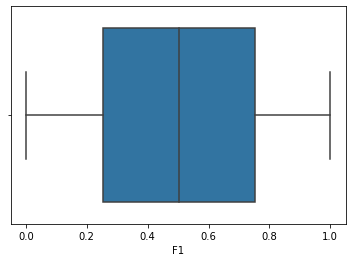

In [105]:
import seaborn as sns
sns.boxplot(x=X['F1'])

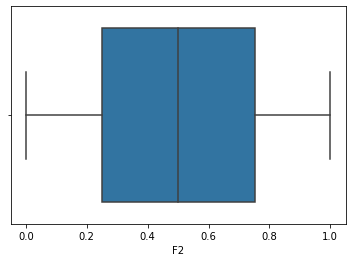

In [106]:
import seaborn as sns
sns.boxplot(x=X['F2'])

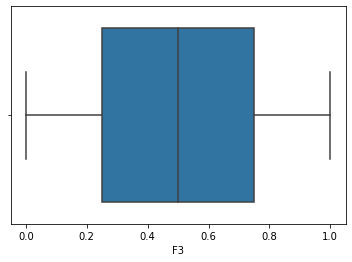

In [107]:
import seaborn as sns
sns.boxplot(x=X['F3'])

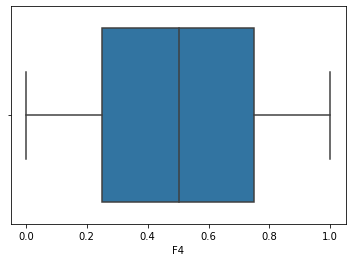

In [108]:
import seaborn as sns
sns.boxplot(x=X['F4'])

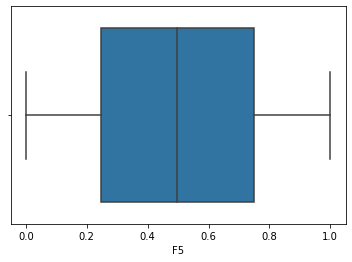

In [109]:
import seaborn as sns
sns.boxplot(x=X['F5'])

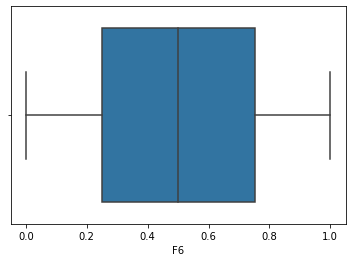

In [110]:
import seaborn as sns
sns.boxplot(x=X['F6'])

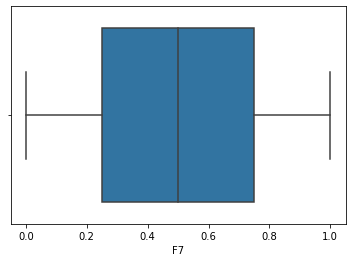

In [111]:
import seaborn as sns
sns.boxplot(x=X['F7'])

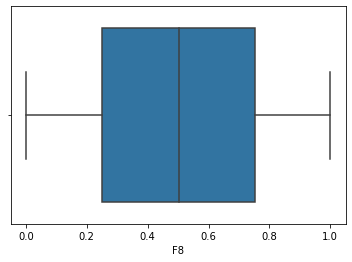

In [112]:
import seaborn as sns
sns.boxplot(x=X['F8'])

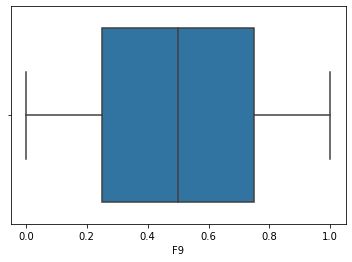

In [113]:
import seaborn as sns
sns.boxplot(x=X['F9'])

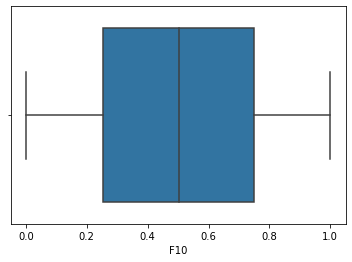

In [114]:
import seaborn as sns
sns.boxplot(x=X['F10'])

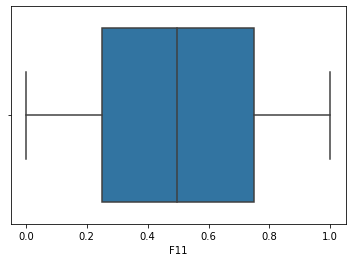

In [115]:
import seaborn as sns
sns.boxplot(x=X['F11'])

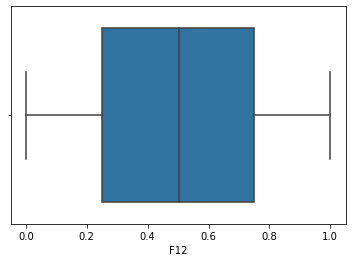

In [116]:
import seaborn as sns
sns.boxplot(x=X['F12'])

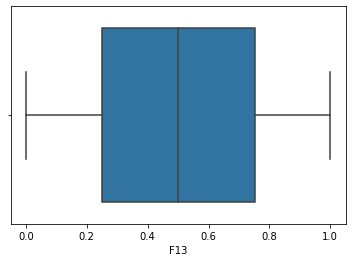

In [117]:
import seaborn as sns
sns.boxplot(x=X['F13'])

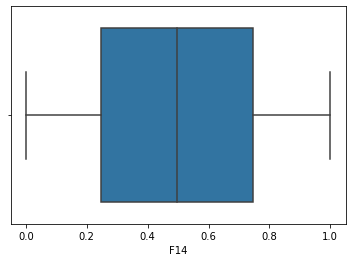

In [118]:
import seaborn as sns
sns.boxplot(x=X['F14'])

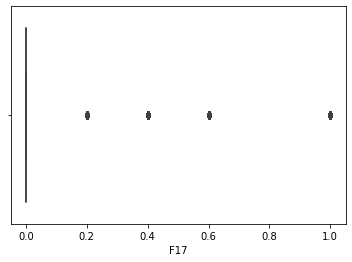

In [119]:
import seaborn as sns
sns.boxplot(x=X['F17'])

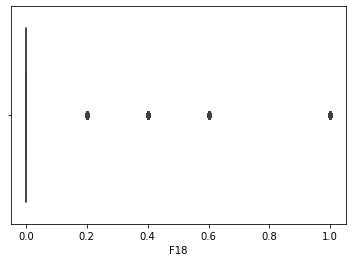

In [120]:
import seaborn as sns
sns.boxplot(x=X['F18'])

In [121]:
#Q1  =  X['F18'].quantile(0.25)
#Q3  = X['F18'].quantile(0.75)
#IQR = Q3 - Q1

In [122]:
#OUT_2 = X[(X['F18'] < Q1-1.5*IQR ) | (X['F18'] > Q3+1.5*IQR)]['F18']

In [123]:
#len(OUT_2)

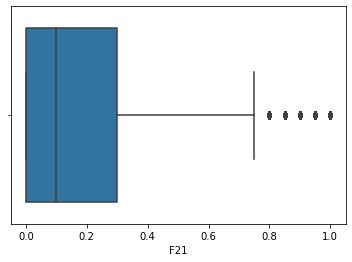

In [124]:
import seaborn as sns
sns.boxplot(x=X['F21'])

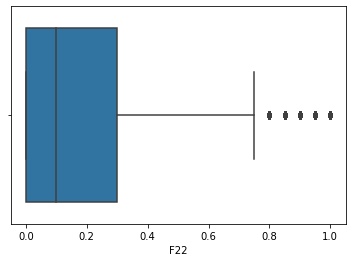

In [125]:
import seaborn as sns
sns.boxplot(x=X['F22'])

Since we have 40% of the population which are outlier we cannt eliminate it since its a large dataset and also by observing the columns it can vbe easily replace by the median the column.

In [126]:
X['F17'].value_counts() 

0.0    81320
0.2    13536
0.4     2426
1.0     2139
0.6     1759
Name: F17, dtype: int64

In [127]:
X['F17'].unique()

array([0.2, 0. , 0.6, 1. , 0.4])

In [128]:
X['F18'].value_counts() 

0.0    81432
0.2    13484
0.4     2436
1.0     2029
0.6     1799
Name: F18, dtype: int64

In [129]:
X['F18'].unique()

array([0. , 0.2, 0.6, 1. , 0.4])

In [130]:
X['F21'].value_counts() 

0.00    41565
0.05     8157
0.10     7229
0.15     7022
0.20     5912
0.25     5138
0.30     4548
0.35     3822
0.45     3261
0.40     3201
0.50     2835
1.00     2807
0.55     1285
0.60     1224
0.65      910
0.70      650
0.75      538
0.80      319
0.85      266
0.90      249
0.95      242
Name: F21, dtype: int64

In [131]:
X['F21'].unique()

array([0.  , 0.85, 0.7 , 0.25, 0.2 , 0.1 , 0.35, 0.4 , 0.15, 1.  , 0.05,
       0.5 , 0.45, 0.55, 0.3 , 0.6 , 0.75, 0.65, 0.9 , 0.95, 0.8 ])

In [132]:

X['F22'].value_counts()

0.00    41408
0.05     8048
0.10     7198
0.15     7103
0.20     6069
0.25     5246
0.30     4519
0.35     3818
0.45     3273
0.40     3167
1.00     2872
0.50     2802
0.55     1319
0.60     1184
0.65     1004
0.70      637
0.75      526
0.80      278
0.85      262
0.95      226
0.90      221
Name: F22, dtype: int64

Since by observing the data column of F17,F18,F21,F22 all are either integer or have some sequence so we cant impute mean to the outlier so choosing median for imputing data ouliers.


**Replacing out-lier by suitbale value**

In [133]:
X['F17'].describe()

count    101180.000000
mean          0.067919
std           0.178813
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: F17, dtype: float64

In [134]:
Q1  =  X['F17'].quantile(0.25)
Q3  = X['F17'].quantile(0.75)
IQR = Q3 - Q1

In [135]:
X['F17'].median()

0.0

In [136]:
IQR

0.0

In [137]:
X['F17'] = np.where(X['F17'] <= Q1-1.5*IQR, 0.0,X['F17'])
X['F17'] = np.where(X['F17'] >=Q3+1.5*IQR, 0.0,X['F17'])

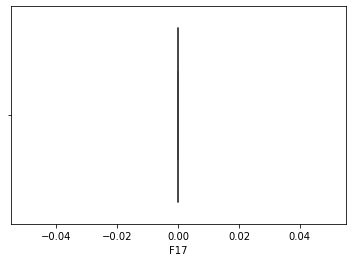

In [138]:
import seaborn as sns
sns.boxplot(x=X['F17'])

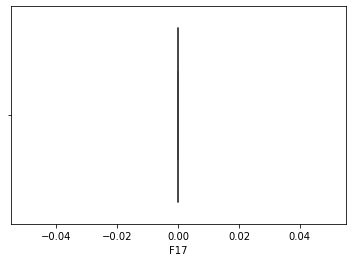

In [139]:
import seaborn as sns
sns.boxplot(x=X['F17'])

In [140]:
X['F18'].describe()

count    101180.000000
mean          0.067005
std           0.176487
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: F18, dtype: float64

In [141]:
Q1  =  X['F18'].quantile(0.25)
Q3  = X['F18'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

0.0


In [142]:


X['F18'].median()

0.0

In [143]:
X['F18'] = np.where(X['F18'] <= Q1-1.5*IQR, 0.0,X['F18'])
X['F18'] = np.where(X['F18'] >=Q3+1.5*IQR, 0.0,X['F18'])

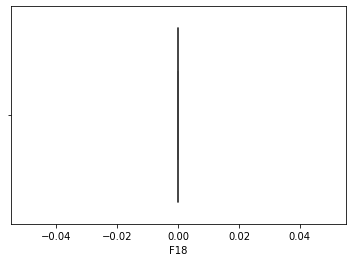

In [144]:
import seaborn as sns
sns.boxplot(x=X['F18'])

In [145]:
X['F21'].describe()

count    101180.000000
mean          0.179402
std           0.238784
min           0.000000
25%           0.000000
50%           0.100000
75%           0.300000
max           1.000000
Name: F21, dtype: float64

In [146]:
Q1  =  X['F21'].quantile(0.25)
Q3  = X['F21'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

0.3


In [147]:
X['F21'].median()

0.1

In [148]:
X['F21'] = np.where(X['F21'] <= Q1-1.5*IQR, 0.0,X['F21'])
X['F21'] = np.where(X['F21'] >=Q3+1.5*IQR, 0.3,X['F21'])

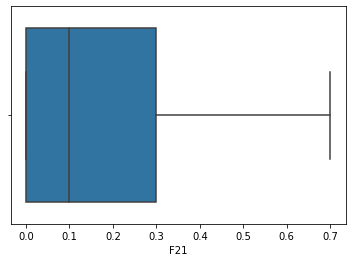

In [149]:
import seaborn as sns
sns.boxplot(x=X['F21'])

In [150]:
X['F22'].describe()

count    101180.000000
mean          0.179928
std           0.238825
min           0.000000
25%           0.000000
50%           0.100000
75%           0.300000
max           1.000000
Name: F22, dtype: float64

In [151]:
Q1  =  X['F22'].quantile(0.25)
Q3  = X['F22'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

0.3


In [152]:
X['F22'].median()

0.1

In [153]:
X['F22'] = np.where(X['F22'] <= Q1-1.5*IQR, 0.0,X['F22'])
X['F22'] = np.where(X['F22'] >=Q3+1.5*IQR, 0.3,X['F22'])

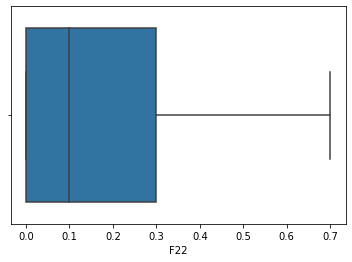

In [154]:
import seaborn as sns
sns.boxplot(x=X['F22'])

In [155]:
#Now All the outlier have been replaced by suitable value.

In [156]:
X.shape

(101180, 18)

**Linear Model with All Features**

In [157]:
#splitting the data
from sklearn import linear_model
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=.2,stratify=Y)

In [158]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(80944, 18)
(20236, 18)
(80944,)
(20236,)


In [159]:
import collections
collections.Counter(y_test)

Counter({0: 15271, 1: 4965})

In [160]:
# Linear model
model = linear_model.SGDClassifier()
model.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [161]:
y_pred = model.predict(X_test)

In [162]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.7546451867958095

In [163]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred)

0.5

**Random Forest with all Features**

In [164]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=3, random_state=0)
clf.fit(X_train, y_train)
y_pred1 = clf.predict(X_test)

In [165]:
accuracy_score(y_test, y_pred1)

0.7546451867958095

In [166]:
roc_auc_score(y_test, y_pred1)

0.5

**Finding Important Features then Removing from Dataframe using chi square test**

In [167]:
from sklearn import svm
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
list_one =[]
feature_ranking = SelectKBest(chi2, k=5)
fit = feature_ranking.fit(X, Y)

fmt = '%-8s%-20s%s'

for i, (score, feature) in enumerate(zip(feature_ranking.scores_, X.columns)):
    list_one.append((score, feature))
    
dfObj = pd.DataFrame(list_one) 
dfObj.sort_values(by=[0], ascending = False)

,0,1
3,26.004079,F4
1,10.839022,F2
16,7.806178,F21
17,5.658069,F22
9,1.157955,F10
11,0.564238,F12
8,0.354551,F9
12,0.275347,F13
0,0.173474,F1
13,0.139376,F14


Deleting variable having low score

In [168]:
X.drop(['F10','F12','F9','F13','F1','F14','F6','F3','F5','F8','F7','F11','F17','F18'],axis=1,inplace=True)

In [169]:
X.shape

(101180, 4)

Since It is quite imbalanced dataset,We need to split it using SMOTE technique.

In [170]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 33)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [171]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X,Y,test_size=.2)

In [172]:
print(X_train1.shape)
print(X_test1.shape)
print(y_train1.shape)
print(y_test1.shape)

(80944, 4)
(20236, 4)
(80944,)
(20236,)


In [173]:
X_train_new, y_train_new = sm.fit_sample(X_train1, y_train1.ravel())

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [174]:
print(X_train_new.shape)
print(X_test1.shape)
print(y_train_new.shape)
print(y_test1.shape)

(122120, 4)
(20236, 4)
(122120,)
(20236,)


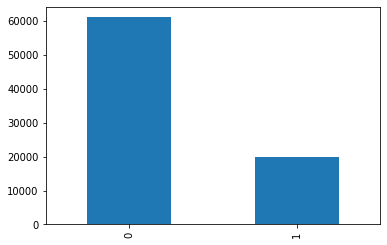

In [175]:
# observe that data has been balanced
pd.Series(y_train1).value_counts().plot.bar()

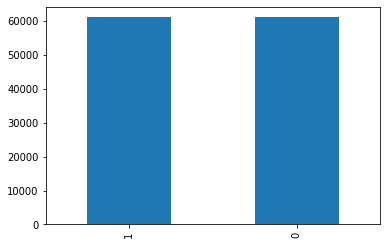

In [176]:
# observe that data has been balanced
pd.Series(y_train_new).value_counts().plot.bar()

Since our new splitted  training data bt SMOTE is balanced for better training of model

**Random Forest Classifier with Feature Selection Dataframe**

In [177]:
clf1 = RandomForestClassifier(n_estimators= 100, max_depth = 3 )
clf1.fit(X_train_new, y_train_new)
y_pred2 = clf1.predict(X_test1)

In [178]:
accuracy_score(y_test1, y_pred2)

0.5396323384067998

In [179]:
roc_auc_score(y_test1, y_pred2)

0.5179719038323753

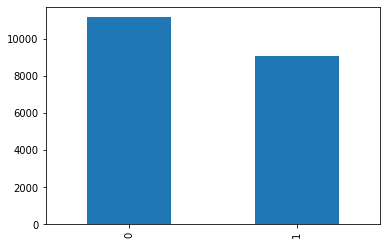

In [180]:
pd.Series(y_pred2).value_counts().plot.bar()

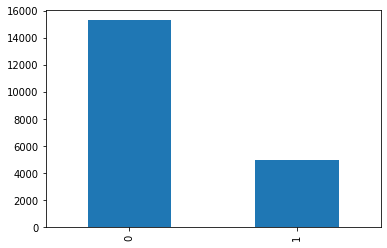

In [181]:
pd.Series(y_test1).value_counts().plot.bar()

In [182]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test1, y_pred2))

              precision    recall  f1-score   support

           0       0.77      0.56      0.65     15293
           1       0.26      0.48      0.34      4943

    accuracy                           0.54     20236
   macro avg       0.51      0.52      0.49     20236
weighted avg       0.64      0.54      0.57     20236



In [183]:
from pandas import read_csv
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

**Estimating MAX. DEPT and N_Estomator for Best accuracy**

Best: -0.555201 using {'n_estimators': 50}
-0.555201 (0.000728) with: {'n_estimators': 50}
-0.555379 (0.000921) with: {'n_estimators': 100}
-0.555585 (0.001016) with: {'n_estimators': 150}
-0.555819 (0.001100) with: {'n_estimators': 200}
-0.556047 (0.001133) with: {'n_estimators': 250}
-0.556233 (0.001222) with: {'n_estimators': 300}
-0.556430 (0.001247) with: {'n_estimators': 350}


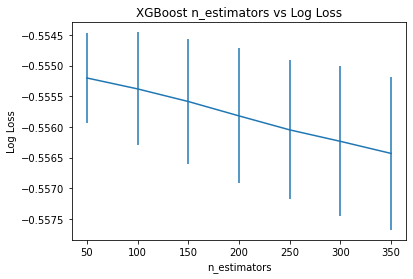

In [184]:
# grid search
model = XGBClassifier()
n_estimators = range(50, 400, 50)
param_grid = dict(n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train1, y_train1)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))
# plot

from matplotlib import pyplot
pyplot.errorbar(n_estimators, means, yerr=stds)
pyplot.title("XGBoost n_estimators vs Log Loss")
pyplot.xlabel('n_estimators')
pyplot.ylabel('Log Loss')
pyplot.savefig('n_estimators.png')

range(1, 11, 2)
Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  4.4min finished


Best: -0.489832 using {'max_depth': 5}
-0.508821 (0.002901) with: {'max_depth': 1}
-0.489897 (0.001982) with: {'max_depth': 3}
-0.489832 (0.002407) with: {'max_depth': 5}
-0.491283 (0.002673) with: {'max_depth': 7}
-0.493968 (0.002810) with: {'max_depth': 9}


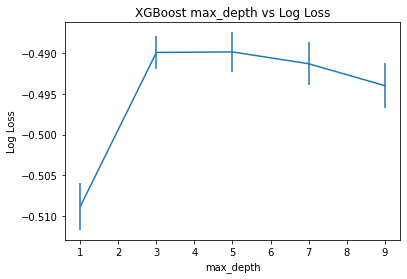

In [76]:
# grid search
model = XGBClassifier()
max_depth = range(1, 11, 2)
print(max_depth)
param_grid = dict(max_depth=max_depth)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(X_train1, y_train1)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))
# plot
from matplotlib import pyplot
pyplot.errorbar(max_depth, means, yerr=stds)
pyplot.title("XGBoost max_depth vs Log Loss")
pyplot.xlabel('max_depth')
pyplot.ylabel('Log Loss')
pyplot.savefig('max_depth.png')

[2, 4, 6, 8]
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 17.1min finished


Best: -0.489021 using {'max_depth': 4, 'n_estimators': 50}
-0.493074 (0.001754) with: {'max_depth': 2, 'n_estimators': 50}
-0.491894 (0.002006) with: {'max_depth': 2, 'n_estimators': 100}
-0.491834 (0.002070) with: {'max_depth': 2, 'n_estimators': 150}
-0.491719 (0.002162) with: {'max_depth': 2, 'n_estimators': 200}
-0.489021 (0.001935) with: {'max_depth': 4, 'n_estimators': 50}
-0.489329 (0.002188) with: {'max_depth': 4, 'n_estimators': 100}
-0.489834 (0.002254) with: {'max_depth': 4, 'n_estimators': 150}
-0.490371 (0.002361) with: {'max_depth': 4, 'n_estimators': 200}
-0.489616 (0.002105) with: {'max_depth': 6, 'n_estimators': 50}
-0.490414 (0.002505) with: {'max_depth': 6, 'n_estimators': 100}
-0.491589 (0.002666) with: {'max_depth': 6, 'n_estimators': 150}
-0.492819 (0.002633) with: {'max_depth': 6, 'n_estimators': 200}
-0.490668 (0.002163) with: {'max_depth': 8, 'n_estimators': 50}
-0.492362 (0.002329) with: {'max_depth': 8, 'n_estimators': 100}
-0.494463 (0.002295) with: {'max_de

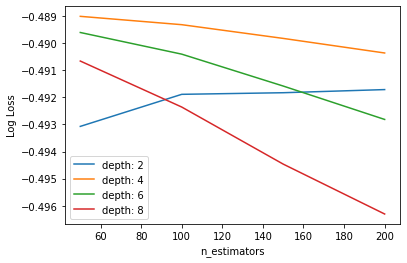

In [78]:
# grid search
model = XGBClassifier()
n_estimators = [50, 100, 150, 200]
max_depth = [2, 4, 6, 8]
print(max_depth)
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(X_train1, y_train1)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))
# plot results
scores = np.array(means).reshape(len(max_depth), len(n_estimators))
for i, value in enumerate(max_depth):
    pyplot.plot(n_estimators, scores[i], label='depth: ' + str(value))
pyplot.legend()
pyplot.xlabel('n_estimators')
pyplot.ylabel('Log Loss')
pyplot.savefig('n_estimators_vs_max_depth.png')

**XGBoost Classifier with Feature Selection Dataframe**

In [185]:
model = XGBClassifier(learning_rate = 0.1, n_estimators=10, min_child_weight=2,  max_depth=3)
model.fit(X_train_new, y_train_new)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=2, missing=None, n_estimators=10, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [186]:
print(X_train_new.shape)
print(X_test1.shape)
print(y_train_new.shape)
print(y_test1.shape)

(122120, 4)
(20236, 4)
(122120,)
(20236,)


In [187]:
X_test1 = X_test1.to_numpy( )

In [188]:
X_test1

array([[0.87385221, 0.5938324 , 0.4       , 0.5       ],
       [0.26893713, 0.20711994, 0.        , 0.05      ],
       [0.27931021, 0.82245757, 0.        , 0.15      ],
       ...,
       [0.33669977, 0.21284836, 0.        , 0.        ],
       [0.98120531, 0.08064346, 0.2       , 0.4       ],
       [0.19662951, 0.671224  , 0.15      , 0.        ]])

In [189]:
y_pred3 = model.predict(X_test1)

In [190]:
accuracy_score(y_test1, y_pred3)

0.6203301047637874

In [191]:
roc_auc_score(y_test1, y_pred3)

0.5180332121766508

In [192]:
import collections
collections.Counter(y_test1)


Counter({0: 15293, 1: 4943})

In [193]:
import collections
collections.Counter(y_pred3)

Counter({0: 14352, 1: 5884})

In [194]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test1, y_pred3))

              precision    recall  f1-score   support

           0       0.77      0.72      0.74     15293
           1       0.27      0.32      0.29      4943

    accuracy                           0.62     20236
   macro avg       0.52      0.52      0.52     20236
weighted avg       0.64      0.62      0.63     20236



**Making Prediction to test_Affinity.txt**

In [195]:
X_test = pd.read_csv('/content/BuyAffinity_Test.txt', sep = '\t')

In [196]:
X_test.head()

,Index,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22
0,T30234341,0.654765,0.812009,0.603190,0.391039,-5220,4825,-1784,7447,-7147,-3461806391,8178108368,-8674321652,8074343777,5553595074,9/17/1996,8/18/1990,1,1,436,478,1,1
1,T30234342,0.694636,0.690568,0.473460,0.259760,-618,-5018,2012,9259,9267,-36253473,-6531193961,1849753082,-5556861821,2216284070,11/7/1985,4/11/1990,1,1,138,56,10,4
2,T30234343,0.203759,0.323301,0.492294,0.011448,-8778,6141,6965,3774,4303,5354243488,8053401796,782597920,-2121815725,-315409510,7/9/1984,5/4/1997,1,1,117,323,10,1
3,T30234344,0.319627,0.286247,0.906197,0.093840,-7929,4471,7715,9543,335,7405036171,-2666864618,-8649240595,1389754605,-3360224957,6/3/1987,7/1/1988,1,1,115,149,16,21
4,T30234345,0.236003,0.782784,0.285689,0.383585,-3296,4564,-1580,-8559,-27,-6351599280,-2152422738,4768902493,3653338555,7604838279,7/17/1984,12/3/1993,1,1,527,281,3,1


In [197]:
X_test.drop(['Index'], axis = 1,inplace = True)

In [198]:
X_test.drop(['F15','F16'], axis = 1,inplace = True)

In [199]:
X_test.drop(['F10','F12','F9','F13','F1','F14','F6','F3','F5','F8','F7','F11','F17','F18', 'F19','F20'],axis=1,inplace=True)

In [200]:
X_=NormalizeData(X_test)

In [201]:
X_.head()

,F2,F4,F21,F22
0,0.812013,0.391073,0.00,0.00
1,0.690569,0.259767,0.45,0.15
2,0.323294,0.011406,0.45,0.00
3,0.286239,0.093815,0.75,1.00
4,0.782787,0.383617,0.10,0.00


In [202]:
X_ = X_.to_numpy( )

In [203]:
y_pred_Final = model.predict(X_)

In [204]:
y_pred_Final

array([1, 0, 0, ..., 0, 0, 0])

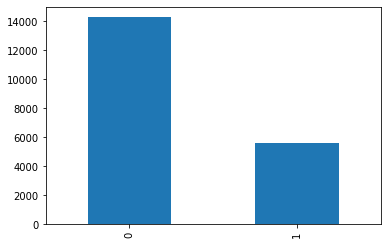

In [205]:
pd.Series(y_pred_Final).value_counts().plot.bar()

In [206]:
X_ = pd.read_csv('/content/BuyAffinity_Test.txt', sep = '\t')

In [207]:
X_['C'] = y_pred_Final

In [208]:
X_.head()

,Index,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,C
0,T30234341,0.654765,0.812009,0.603190,0.391039,-5220,4825,-1784,7447,-7147,-3461806391,8178108368,-8674321652,8074343777,5553595074,9/17/1996,8/18/1990,1,1,436,478,1,1,1
1,T30234342,0.694636,0.690568,0.473460,0.259760,-618,-5018,2012,9259,9267,-36253473,-6531193961,1849753082,-5556861821,2216284070,11/7/1985,4/11/1990,1,1,138,56,10,4,0
2,T30234343,0.203759,0.323301,0.492294,0.011448,-8778,6141,6965,3774,4303,5354243488,8053401796,782597920,-2121815725,-315409510,7/9/1984,5/4/1997,1,1,117,323,10,1,0
3,T30234344,0.319627,0.286247,0.906197,0.093840,-7929,4471,7715,9543,335,7405036171,-2666864618,-8649240595,1389754605,-3360224957,6/3/1987,7/1/1988,1,1,115,149,16,21,0
4,T30234345,0.236003,0.782784,0.285689,0.383585,-3296,4564,-1580,-8559,-27,-6351599280,-2152422738,4768902493,3653338555,7604838279,7/17/1984,12/3/1993,1,1,527,281,3,1,0


In [209]:
final = X_.filter(['Index','C'],axis=1)

In [210]:
final.head()

,Index,C
0,T30234341,1
1,T30234342,0
2,T30234343,0
3,T30234344,0
4,T30234345,0


In [211]:
final.to_csv('prediction_Ravite_Anand.csv',index=False,header=True)

In [212]:
import pickle

In [214]:
from sklearn.externals import joblib 

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [215]:
# Save the model as a pickle in a file 
joblib.dump(model, '/content/saved_model.pkl') 

['/content/saved_model.pkl']